In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import os
import pdb
import numpy as np
import numpy.random as npr
import tensorflow as tf
import sys
import matplotlib.pyplot as plt
import re
from sklearn.decomposition import PCA
from numpy import linalg as LA
from scipy.spatial import distance
from scipy.linalg import subspace_angles
from scipy import stats
from sklearn import linear_model
from scipy.linalg import subspace_angles

PATH_YANGNET = '/Users/lauradriscoll/Documents/code/yangnet/training' #'/home/laura/code/yangnet/training'
sys.path.insert(0, PATH_YANGNET)
from task import generate_trials, rule_name, rule_index_map, rules_dict
from network import Model
import tools
cmap=plt.get_cmap('rainbow')

from tools_lnd import gen_trials_from_model_dir, gen_X_from_model_dir, gen_X_from_model_dir_epoch, name_best_ckpt, find_ckpts, get_model_params


/Users/lauradriscoll/anaconda2/lib/python2.7/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [46]:
def plot_diff(dist_go_anti):
    cmap = plt.get_cmap('cool')
    ind_begin = 0
    for ind_begin in range(np.shape(dist_go_anti)[0]):
        c = cmap(ind_begin/np.shape(dist_go_anti)[0])
        plt.plot(np.mean(dist_go_anti[ind_begin,:,:],axis = 1),'-',lineWidth = .5,c = c,alpha = .8)
    plt.xlabel('$\\Delta   \\theta$')
    plt.ylabel('log Euclidean Distance')
    plt.xticks(range(0,401,100),('0','$\pi$ / 2','$\pi$','$3 \pi$ / 2','$2 \pi$'))
    t = epoch + '_' + rule + '_delayanti'
    plt.title(t)

def plot_ring(X_reg,X_pca,stim_locs,label,pc1=0,pc2=1):
    fig = plt.figure(figsize=(8, 4),tight_layout=True,facecolor='white')
    plt.rcParams.update({'font.size': 12})
    
    ax = fig.add_subplot(1,2,1)
    plt.scatter(X_reg[pc1,:],X_reg[pc2,:],20,stim_locs,cmap = 'rainbow')
    plt.title(label + ' tdr space : ' + str(np.round(np.var(X_reg,axis = 1),decimals=2)))
    
    ax = fig.add_subplot(1,2,2)
    plt.scatter(X_pca[pc1,:],X_pca[pc2,:],20,stim_locs,cmap = 'rainbow')
    plt.title('pc space : ' + str(np.round(np.var(X_pca,axis = 1),decimals=2)))
    
#     for t in range(len(inds)-1):
#         c = cmap(t/len(inds))
#         t_inds = range(inds[t],inds[t+1])
#         plt.plot(X[pc1,t_inds],X[pc2,t_inds],c=c)
 
    plt.show()
    
def plot_ring_anti(X_reg,X_pca,stim_locs,label,t_ind,pc1=0,pc2=1):
    fig = plt.figure(figsize=(4, 4),tight_layout=True,facecolor='white')
    plt.rcParams.update({'font.size': 12})
    
    plt.scatter(X_reg[pc1,:],X_reg[pc2,:],20,stim_locs,cmap = 'rainbow')
    plt.scatter(X_pca[pc1,:],X_pca[pc2,:],20,stim_locs,cmap = 'rainbow',marker = 'd')
    plt.title('anti vs ' + label + ' tdr space : t = ' + str(t_ind))
    
    plt.show()
    
def zscore(X):
    X_zscore = stats.zscore(X, axis=1)
    X_zscore_nonan = X_zscore
    X_zscore_nonan[np.isnan(X_zscore)] = 0
    return X_zscore_nonan

def denoise(X,n_pcs):
    # 6.5. Principal component analysis (Mante Sussillo)
    pca = PCA(n_components=n_pcs)
    pca.fit(X)
    v_a = pca.transform(X)
    return np.dot(v_a,v_a.T)

def angle(v1, v2):
    return np.arccos(np.dot(v1, v2) / (len(v1) * len(v2)))

In [47]:
model_n = 0
dir_specific_all = 'grad_norm_l2h000001'#'combos'#'grad_norm_l2001' #'grad_norm_l2001' ##'grad_norm_l2001' #
model_dir_all = os.path.join('/Users/lauradriscoll/Documents/data/rnn/multitask/lowD/',
                             dir_specific_all,'most',str(model_n))
model = Model(model_dir_all)
ckpt_n = name_best_ckpt(model_dir_all,'delaygo')#
ckpt_n_dir = os.path.join(model_dir_all,'ckpts/model.ckpt-' + str(int(ckpt_n)))
fldr = os.path.join('ncm/subspace_angles/',dir_specific_all,str(model_n))
if not os.path.exists(fldr):
    os.makedirs(fldr)

Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>


Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/lowD/grad_norm_l2h000001/most/0/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/lowD/grad_norm_l2h000001/most/0/model.ckpt
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/lowD/grad_norm_l2h000001/most/0/model.ckpt

/Users/lauradriscoll/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:61: RuntimeWarning: divide by zero encountered in log


Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/lowD/grad_norm_l2h000001/most/0/ckpts/model.ckpt-156000
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/lowD/grad_norm_l2h000001/most/0/ckpts/model.ckpt-156000
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype

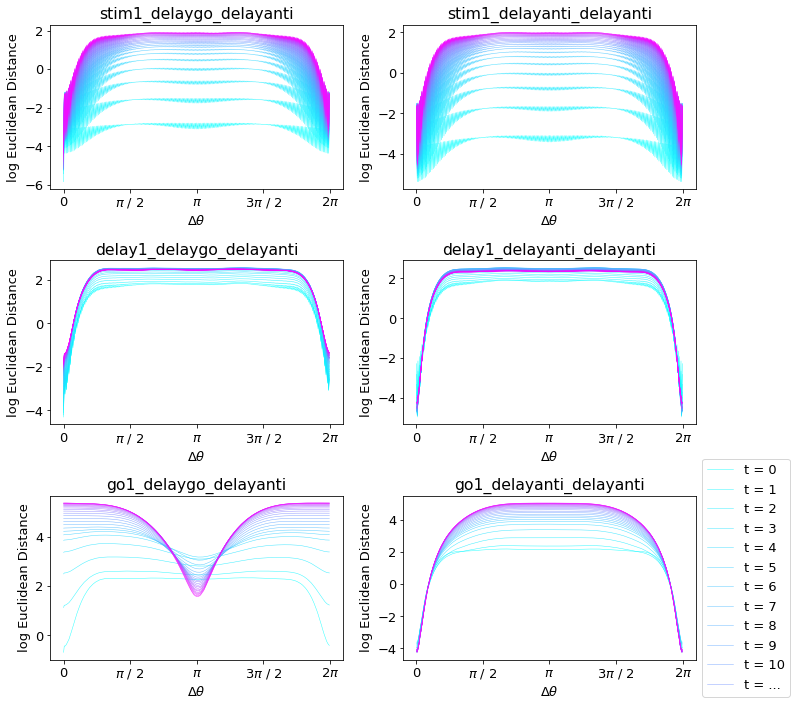

In [48]:
rule_set = ['delaygo','delayanti']
epoch_set = ['stim1','delay1','go1'] #'fix1',
Q = {}
p_vc = {}
p_vc_anti = {}
dist_go_anti = {}

fig = plt.figure(figsize=(10, 10),tight_layout=True,facecolor='white')
plt.rcParams.update({'font.size': 13})

# for rule in rule_set:
for ri in range(len(rule_set)):
    rule = rule_set[ri]
    trial = gen_trials_from_model_dir(model_dir_all,rule)
    trial_anti = gen_trials_from_model_dir(model_dir_all,'delayanti')
    stim_locs = np.expand_dims(trial.stim_locs,axis = 1)
    n_stim = np.shape(trial.stim_locs)[0]
    F = np.concatenate((np.cos(stim_locs),np.sin(stim_locs)),axis = 1)
    #     targ_locs_go = stim_locs
    #     targ_locs_anti = np.expand_dims((trial.stim_locs+np.pi)%2*np.pi,axis = 1)

    for ei in range(len(epoch_set)):
        epoch = epoch_set[ei]
        X = gen_X_from_model_dir_epoch(model_dir_all,ckpt_n_dir,trial,epoch)
        X_anti = gen_X_from_model_dir_epoch(model_dir_all,ckpt_n_dir,trial_anti,epoch)
        N,Obsrv = np.shape(X) # neurons x trials (stim)
        dist_go_anti[epoch] = np.zeros((int(Obsrv/n_stim),n_stim,n_stim))

        for ind_begin in range(0,int(Obsrv/n_stim)):
            #use inds at the end of each epoch
            inds = range(ind_begin,Obsrv,int(Obsrv/n_stim))
            r = zscore(X[:,inds])
            r_anti = zscore(X_anti[:,inds])
            for offset in range(n_stim):
                inds_anti = [int(j) for j in np.concatenate((inds[offset:n_stim],inds[0:offset]))]
                dist_go_anti[epoch][ind_begin,offset,:] = np.square(np.sum(np.power(X[:,inds]-X_anti[:,inds_anti],2),axis = 0))

#             # find beta weights for neurons to sin, cos theta
#             lm = linear_model.LinearRegression()
#             model = lm.fit(F,r.T)
#             Beta = model.coef_

#             # 6.5. Principal component analysis (Mante Sussillo)
#             n_pcs=256 #not really denoising because fullspace
#             D = denoise(r,n_pcs)

#             # 6.7. Regression Subspace
#             Beta_pca = np.dot(D,Beta)
#             Q[rule,epoch], _ = LA.qr(Beta_pca)
#     #             print(np.dot(Q[rule,epoch][:,0],Q[rule,epoch][:,1]))
#     #             print(np.dot(Beta_pca[:,0],Beta_pca[:,1]))
#             p_vc[rule,epoch] = np.dot(Q[rule,epoch].T,r)
#             p_vc_anti[rule,epoch] = np.dot(Q[rule,epoch].T,r_anti)

#             # Compare regression subspace to pca subspace
#             pca = PCA(n_components=2)
#             r_pca = pca.fit_transform(r.T)
#     #             plot_ring(p_vc[rule,epoch],r_pca.T,stim_locs[:,0],rule+'_'+epoch)
#     #             plot_ring_anti(p_vc[rule,epoch],p_vc_anti[rule,epoch],stim_locs[:,0],rule+'_'+epoch, ind_begin)
        ax = fig.add_subplot(len(epoch_set),len(rule_set),ei*len(rule_set)+ri+1)
        plot_diff(np.log(dist_go_anti[epoch]))
    
plt.legend(('t = 0','t = 1','t = 2','t = 3','t = 4','t = 5','t = 6','t = 7','t = 8','t = 9','t = 10','t = ...'),
               loc='center left', bbox_to_anchor=(1, 0.5))
fig_title = 'diff_btween_trials_' + dir_specific_all + '_ckpt_'+ str(ckpt_n) + '_model_' + str(model_n) + '.svg'
plt.savefig('ncm/subspace_angles_tdr/' + 'log_' + fig_title)
plt.show()

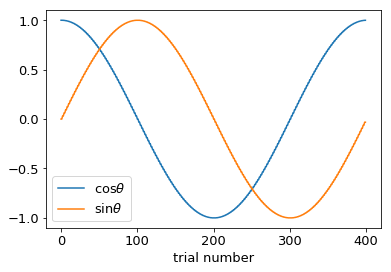

In [42]:
plt.plot(F)
plt.legend(('cos$\\theta$','sin$\\theta$'))
plt.xlabel('trial number')
plt.show()

In [35]:
# 6.3. Linear Regression
rule = 'delaygo'
epoch = 'go1'

trial = gen_trials_from_model_dir(model_dir_all,rule)
stim_locs = np.expand_dims(trial.stim_locs,axis = 1)
s = np.shape(trial.stim_locs)[0]
F = np.concatenate((np.cos(stim_locs),np.sin(stim_locs)),axis = 1)

X = gen_X_from_model_dir_epoch(model_dir_all,ckpt_n_dir,trial,epoch)
N,S = np.shape(X) # neurons x trials (stim)

inds = range(int(S/s)-1,S,int(S/s))
X_zscore = stats.zscore(X, axis=1)
X_zscore_nonan = X_zscore
X_zscore_nonan[np.isnan(X_zscore)] = 0
r = X_zscore_nonan[:,inds]

lm = linear_model.LinearRegression()
model = lm.fit(F,r.T)
Beta = model.coef_

Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/lowD/grad_norm_l2001/most/1/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/lowD/grad_norm_l2001/most/1/model.ckpt
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/lowD/grad_norm_l2001/most/1/ckpts/model.ckpt-95000

In [22]:
# 6.5. Principal component analysis
n_pcs = 12

pca = PCA(n_components=n_pcs)
pca.fit(X_zscore_nonan)
v_a = pca.transform(X_zscore_nonan)
D = np.dot(v_a,v_a.T)

# 6.7. Regression Subspace
Beta_pca = np.dot(D,Beta)
Q,_ = LA.qr(Beta_pca)
p_vc = np.dot(Q.T,X_zscore_nonan)
plot_ring(p_vc,stim_locs,inds,rule +'_'+ epoch)

AttributeError: 'list' object has no attribute 'shape'

In [23]:
# 6.7. Regression Subspace
X_zscore_nonan_denoise = np.dot(D,X_zscore_nonan)


pca = PCA(n_components=2)
X_zscore_nonan_pca = pca.fit_transform(X_zscore_nonan_denoise[:,inds].T).T
denom = np.sum(np.var(X_zscore_nonan_denoise[:,inds],axis=1))
print('tdr variance explained dim 1, 2 :' + str(np.var(p_vc[:,inds],axis=1)/denom))
print('pca variance explained pc 1, 2 :' + str(np.var(X_zscore_nonan_pca,axis=1)/denom))

pca = PCA(n_components=2)
X_zscore_nonan_pca = pca.fit_transform(X_zscore_nonan[:,inds].T).T    
X_zscore_nonan_pca = pca.transform(X_zscore_nonan.T).T

plot_ring(p_vc,stim_locs,inds,'tdr space')

plot_ring(X_zscore_nonan_pca,stim_locs,inds,'pca space')

tdr variance explained dim 1, 2 :[3.30341206e-11 2.54518373e-11]
pca variance explained pc 1, 2 :[0.58314365 0.34181288]


AttributeError: 'list' object has no attribute 'shape'

In [ ]:
pc_set = range(2)#range(0,int(s/2),int(s/4))#range(0,int(s/2),int(s/4))
sa_epoch = np.zeros((len(rule_set),len(epoch_set),len(epoch_set)))
sa_rule = np.zeros((len(rule_set),len(rule_set),len(epoch_set)))

for rule1,ri1 in zip(rule_set,range(len(rule_set))):
    for epoch1,ei1 in zip(epoch_set,range(len(epoch_set))):
        for epoch2,ei2 in zip(epoch_set,range(len(epoch_set))):
            sa_epoch[ri1,ei1,ei2] = np.mean(np.rad2deg(
                subspace_angles(Q[rule1,epoch1][pc_set,:].T, 
                                Q[rule1,epoch2][pc_set,:].T)))
            for rule2,ri2 in zip(rule_set,range(len(rule_set))):
                sa_rule[ri1,ri2,ei1] = np.mean(np.rad2deg(
                    subspace_angles(Q[rule1,epoch1][pc_set,:].T, 
                                    Q[rule2,epoch1][pc_set,:].T)))
                
fig = plt.figure(figsize=(20, 4),tight_layout=True,facecolor='white')
plt.rcParams.update({'font.size': 13})

for ri1 in range(len(rule_set)):
    ax = fig.add_subplot(1,len(rule_set),ri1+1)
    plt.imshow(sa_epoch[ri1,:,:],vmin = 0,vmax = 180,cmap = 'gray')
    plt.title(rule_set[ri1])
    plt.colorbar()
    plt.xticks(np.arange(len(epoch_set)),epoch_set)
    plt.yticks(np.arange(len(epoch_set)),epoch_set)
    for (j,i),label in np.ndenumerate(sa_epoch[ri1,:,:]):
        ax.text(i,j,round(label),ha='center',va='center',color='white')
plt.savefig('ncm/subspace_angles_tdr/' + 'epoch_set_w_in_rule_' + dir_specific_all + '_ckpt_'+ str(ckpt_n) + '_model_' + str(model_n) + '.svg')
plt.show()

fig = plt.figure(figsize=(20, 4),tight_layout=True,facecolor='white')
plt.rcParams.update({'font.size': 13})

for ei1 in range(len(epoch_set)):
    ax = fig.add_subplot(1,len(epoch_set),ei1+1)
    plt.imshow(sa_rule[:,:,ei1],vmin = 0,vmax = 180,cmap = 'gray')
    plt.title(epoch_set[ei1])
    plt.colorbar()
    plt.xticks(np.arange(len(rule_set)),rule_set)
    plt.yticks(np.arange(len(rule_set)),rule_set)
    for (j,i),label in np.ndenumerate(sa_rule[:,:,ei1]):
        ax.text(i,j,round(label),ha='center',va='center',color='white')
plt.savefig('ncm/subspace_angles_tdr/' + 'rule_set_w_in_epoch_' + dir_specific_all + '_ckpt_'+ str(ckpt_n) + '_model_' + str(model_n) + '.svg')
plt.show()